Save and Imports 

In [1]:
import scanpy as sc
import squidpy as sq
import scvi
import matplotlib.pyplot as plt


/home/megha/miniconda3/envs/spatial_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/megha/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/megha/miniconda3/envs/spatial_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Integrated Data

In [2]:
import scanpy as sc

adata = sc.read(r"/mnt/c/Users/megha/Desktop/project/results/integrated/integrated.h5ad")

adata


AnnData object with n_obs × n_vars = 25044 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'sample_id', 'integrated_leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'dendrogram_integrated_leiden', 'hvg', 'integrated_leiden', 'integrated_leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_id_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Visualization

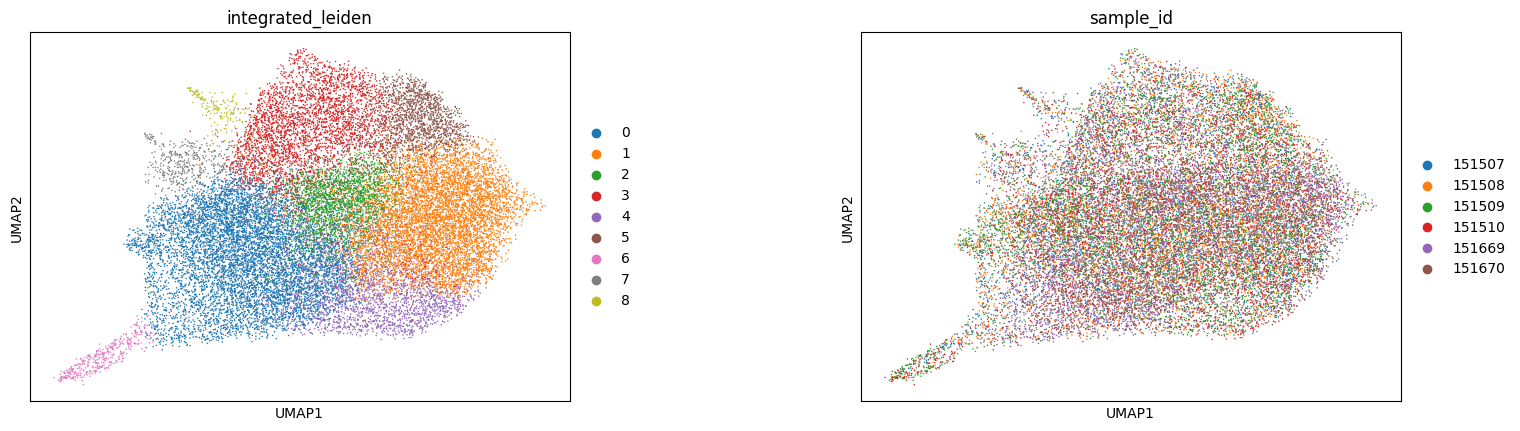

In [3]:
sc.pl.umap(adata, color=["integrated_leiden", "sample_id"], wspace=0.4)


Spatial Graph Construction

In [4]:
sq.gr.spatial_neighbors(adata)


Moran’s I

Make cluster numeric

In [5]:
adata.obs["leiden_numeric"] = adata.obs["integrated_leiden"].astype(int)


Compute spatial neighbors

In [6]:
sq.gr.spatial_neighbors(adata)


Compute Moran’s I manually

In [7]:
# make sure numeric column exists
adata.obs["leiden_numeric"] = adata.obs["integrated_leiden"].astype(int)

# compute spatial neighbors (if not already done)
sq.gr.spatial_neighbors(adata)

# compute Moran's I on obs column
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=["leiden_numeric"],
    attr="obs",
    n_perms=100
)


100%|██████████| 100/100 [00:00<00:00, 124.23/s]


In [8]:
adata.uns["moranI"]


,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
leiden_numeric,0.241267,0.0,0.000013,0.0,0.009901,0.000012,0.0,0.0,0.009901


Extract the Clean Number

In [19]:
moran_value = adata.uns["moranI"]["I"].values[0]
p_value = adata.uns["moranI"]["pval_sim"].values[0]

moran_value, p_value


(np.float64(0.24126652019139355), np.float64(0.009900990099009901))

Figures

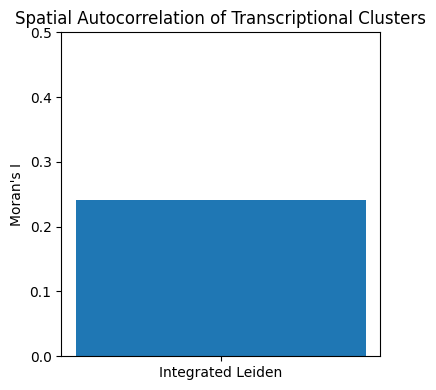

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.bar(["Integrated Leiden"], [moran_value])
plt.ylim(0, 0.5)
plt.ylabel("Moran's I")
plt.title("Spatial Autocorrelation of Transcriptional Clusters")
plt.tight_layout()
plt.show()


In [21]:
plt.savefig("moran_integrated.png", dpi=300)


<Figure size 640x480 with 0 Axes>

Spatial Context Figure

In [23]:
adata = sc.read("/mnt/c/Users/megha/Desktop/project/results/integrated/integrated.h5ad")


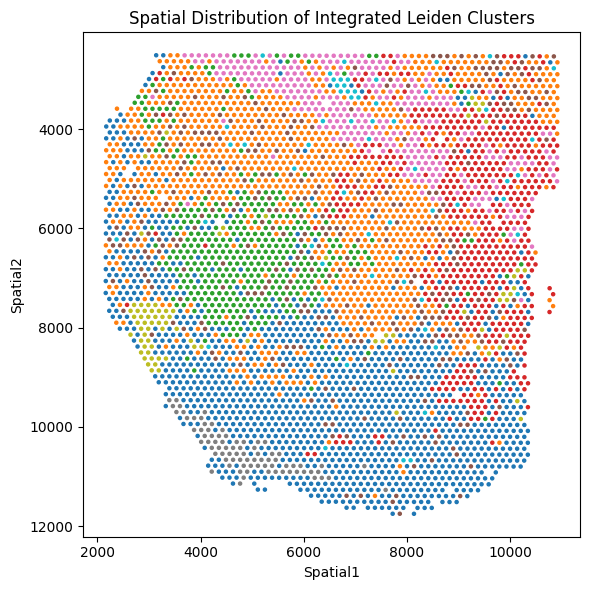

In [26]:
import matplotlib.pyplot as plt

sample = "151507"
sub = adata[adata.obs["sample_id"] == sample]

coords = sub.obsm["spatial"]
clusters = sub.obs["integrated_leiden"].astype(int)

plt.figure(figsize=(6,6))
plt.scatter(
    coords[:, 0],
    coords[:, 1],
    c=clusters,
    s=5,
    cmap="tab10"
)

plt.gca().invert_yaxis()
plt.title("Spatial Distribution of Integrated Leiden Clusters")
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.tight_layout()
plt.show()


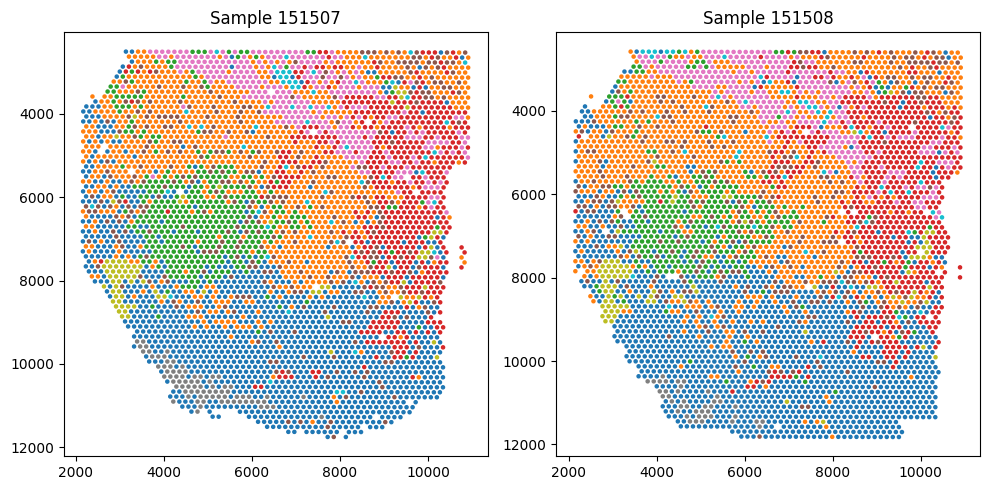

In [27]:
samples_to_show = ["151507", "151508"]

fig, axes = plt.subplots(1, 2, figsize=(10,5))

for ax, sample in zip(axes, samples_to_show):
    sub = adata[adata.obs["sample_id"] == sample]
    coords = sub.obsm["spatial"]
    clusters = sub.obs["integrated_leiden"].astype(int)

    ax.scatter(coords[:,0], coords[:,1], c=clusters, s=5, cmap="tab10")
    ax.invert_yaxis()
    ax.set_title(f"Sample {sample}")

plt.tight_layout()
plt.show()
